In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy import optimize


In [5]:
def calculate_relaxation_times(T, X_CO2, X_N2, X_H2O, p):
    """
    Calculate vibrational relaxation times for a CO2-N2-H2O gas mixture.
    
    Parameters:
    -----------
    T : float
        Temperature in Kelvin
    X_CO2 : float
        Mole fraction of CO2
    X_N2 : float
        Mole fraction of N2
    X_H2O : float
        Mole fraction of H2O
    p : float, optional
        Pressure in atm, default is 1.0
        
    Returns:
    --------
    tuple
        (tau_a, tau_b) where:
        tau_a is the relaxation time for CO2 modes v1 and v2 (in seconds)
        tau_b is the relaxation time for N2 vibrational energy (in seconds)
    """
    import math
    
    # Validate inputs
    if T <= 0:
        T = 1  # Default temperature if invalid
    
    if any(x < 0 for x in [X_CO2, X_N2, X_H2O]):
        raise ValueError(f"Mole fractions must be non-negative, got CO2: {X_CO2}, N2: {X_N2}, H2O: {X_H2O}")
    
    sum_fractions = X_CO2 + X_N2 + X_H2O
    if abs(sum_fractions - 1.0) > 1e-6:
        print(f"Warning: Mole fractions sum to {sum_fractions}, not 1.0")
    
    # Calculate T^(-1/3) which is used in multiple equations
    T_pow_neg_1_3 = T**(-1/3)
    
    # Calculate individual relaxation times based on the equations
    
    # τₐp for CO2-N2
    tau_a_p_CO2_N2 = 1.3 * 10**5 * (T_pow_neg_1_3)**4.9
    
    # τₐp for CO2-CO2
    tau_a_p_CO2_CO2 = 0.27 * tau_a_p_CO2_N2
    
    # τₐp for CO2-H2O
    tau_a_p_CO2_H2O = 5.5 * 10**(-2)
    
    # τᵦp for N2-N2
    log_tau_b_p_N2_N2 = 93 * T_pow_neg_1_3 - 4.61
    tau_b_p_N2_N2 = 10**log_tau_b_p_N2_N2
    
    # τᵦp for N2-CO2
    tau_b_p_N2_CO2 = tau_b_p_N2_N2
    
    # τᵦp for N2-H2O
    log_tau_b_p_N2_H2O = 27.65 * T_pow_neg_1_3 - 3.2415
    tau_b_p_N2_H2O = 10**log_tau_b_p_N2_H2O
    
    # For τₐ (Mode I: CO2 modes v1 and v2)
    # Using formula: 1/τₐ = X_CO2/(τₐp)_CO2-CO2 + X_N2/(τₐp)_CO2-N2 + X_H2O/(τₐp)_CO2-H2O
    inv_tau_a = X_CO2 / tau_a_p_CO2_CO2 + X_N2 / tau_a_p_CO2_N2 + X_H2O / tau_a_p_CO2_H2O
    tau_a = 1 / (p * inv_tau_a)  # Convert from atm·s to s
    
    # For τᵦ (N2 vibrational energy)
    # Using formula: 1/τᵦ = X_CO2/(τᵦp)_N2-CO2 + X_N2/(τᵦp)_N2-N2 + X_H2O/(τᵦp)_N2-H2O
    inv_tau_b = X_CO2 / tau_b_p_N2_CO2 + X_N2 / tau_b_p_N2_N2 + X_H2O / tau_b_p_N2_H2O
    tau_b = 1 / (p * inv_tau_b)  # Convert from atm·s to s
    
    # for tau_c 
    tau_c_p_CO2_CO2 = 10**(17.8 * T_pow_neg_1_3 - 1.808)
    tau_c_p_CO2_N2 = 2.0 * tau_c_p_CO2_CO2
    
    if T > 600:
        tau_c_p_CO2_H2O = 10**(-20.4 * T_pow_neg_1_3 + 0.643)
    else:
        tau_c_p_CO2_H2O = 10**(-20.4 * 600**(-1/3) + 0.643)

    inv_tau_c = X_CO2 / tau_c_p_CO2_CO2 + X_N2 / tau_c_p_CO2_N2 + X_H2O / tau_c_p_CO2_H2O
    tau_c = 1 / (p * inv_tau_c)  # Convert from atm·s to s

    tau_I = tau_c
    tau_II = 1/(((X_CO2 / tau_a) + (X_N2 / tau_b))/(X_CO2 + X_N2))

    return tau_I * 10**(-6), tau_II * 10**(-6)  # Convert to seconds

In [6]:
## Sanity check relaxation times
T = 300  # K
X_CO2 = 0.09
X_N2 = 0.90
X_H2O = 0.01
p = 1.0  # atm
tau_a, tau_b = calculate_relaxation_times(T, X_CO2, X_N2, X_H2O, p)
print(f"Relaxation times for T={T} K, X_CO2={X_CO2}, X_N2={X_N2}, X_H2O={X_H2O}, p={p} atm:")
print(f"tau_a: {tau_a:.2e} s")
print(f"tau_b: {tau_b:.2e} s")
print(f"ratio tau_a/tau_b: {tau_a/tau_b:.2f}")

Relaxation times for T=300 K, X_CO2=0.09, X_N2=0.9, X_H2O=0.01, p=1.0 atm:
tau_a: 1.49e-06 s
tau_b: 3.66e-05 s
ratio tau_a/tau_b: 0.04


In [7]:
import math
def vib_energy_I(T, X_CO2, X_N2, X_H2O):
    """
    Calculate the vibrational energy of CO2 modes v1 and v2.
    
    Parameters:
    -----------
    T : float
        Temperature in Kelvin
    X_CO2 : float
        Mole fraction of CO2
    X_N2 : float
        Mole fraction of N2
    X_H2O : float
        Mole fraction of H2O
        
    Returns:
    --------
    float
        Vibrational energy of CO2 modes v1 and v2 (in J/kg)
    """
    # Constants
    R = 188.92 # J / kg·K 
    k = 1.380649e-23 # J/K (Boltzmann constant)
    # hc is planck's constant times speed of light in cm
    hc = 6.62607015e-34 * 2.998e10 # J·cm (Planck's constant times speed of light)
    # Calculate mass fraction from the mole fraction and molar mass of CO2, N2, H2O
    M_CO2 = 44.01 # g/mol
    M_N2 = 28.02 # g/mol
    M_H2O = 18.02 # g/mol
    M_total = X_CO2 * M_CO2 + X_N2 * M_N2 + X_H2O * M_H2O
    c_CO2 = (X_CO2 * M_CO2) / M_total 

    # energy transition wavenumbers
    v1 = 1388.0 # cm^-1
    v2 = 667.0 # cm^-1
    
    # Calculate the vibrational energy using the formula
    E_vib = (c_CO2 * R * (hc * v1 / (np.exp(hc * v1 / (k * T)) - 1) + hc * v2 / (np.exp(hc * v2 / (k * T)) - 1)))/k

    return E_vib

def vib_energy_II(T, X_CO2, X_N2, X_H2O):
    """
    Calculate the vibrational energy of N2 and CO2 mode 3 (in equilibrium due to collisions).
    
    Parameters:
    -----------
    T : float
        Temperature in Kelvin
    X_CO2 : float
        Mole fraction of CO2
    X_N2 : float
        Mole fraction of N2
    X_H2O : float
        Mole fraction of H2O
        
    Returns:
    --------
    float
        Vibrational energy of mode II (in J/mol)
    """
    # Constants
    R_co2 = 188.92 # J / kg·K 
    R_n2 = 296.8 # J / kg·K
    k = 1.380649e-23 # J/K (Boltzmann constant)
    # hc is planck's constant times speed of light in cm
    hc = 6.62607015e-34 * 2.998e10 # J·cm (Planck's constant times speed of light)
    
    # Calculate mass fraction from the mole fraction and molar mass of CO2, N2, H2O
    M_CO2 = 44.01 # g/mol
    M_N2 = 28.02 # g/mol
    M_H2O = 18.02 # g/mol
    M_total = X_CO2 * M_CO2 + X_N2 * M_N2 + X_H2O * M_H2O
    c_CO2 = (X_CO2 * M_CO2) / M_total
    c_N2 = (X_N2 * M_N2) / M_total 

    # energy transition wavenumbers for N2 modes
    v1 = 2330.0 # cm^-1
    v3 = 2349.0 # cm^-1
    
    # Calculate the vibrational energy using the formula
    E_vib = (c_N2 * R_n2 * (hc * v1 / (np.exp(hc * v1 / (k * T)) - 1)) + c_CO2 * R_co2 * (hc * v3 / (np.exp(hc * v3 / (k * T)) - 1)))/k
    
    return E_vib

In [8]:
def find_vib_temperature(energy_level, X_CO2, X_N2, X_H2O, mode='I', T_initial=1000.0, tol=1e-6):
    """
    Find the vibrational temperature corresponding to a given vibrational energy level
    using SciPy's Newton's method.
    
    Parameters:
    -----------
    energy_level : float
        Target vibrational energy level (in J/mol)
    X_CO2 : float
        Mole fraction of CO2
    X_N2 : float
        Mole fraction of N2
    X_H2O : float
        Mole fraction of H2O
    mode : str, optional
        'I' for CO2 modes v1 and v2, 'II' for N2 and CO2 mode v3, default is 'I'
    T_initial : float, optional
        Initial guess for temperature in K, default is 1000.0
    tol : float, optional
        Tolerance for convergence, default is 1e-6
    
    Returns:
    --------
    float
        Vibrational temperature in Kelvin
    """
    # Select the appropriate energy function based on the mode
    if mode.upper() == 'I':
        energy_func = vib_energy_I
    elif mode.upper() == 'II':
        energy_func = vib_energy_II
    else:
        raise ValueError("Mode must be 'I' or 'II'")
    
    # Define the objective function: f(T) = E(T) - target_energy
    def objective(T):
        return energy_func(T, X_CO2, X_N2, X_H2O) - energy_level
    
    # Use SciPy's newton method
    result = optimize.newton(objective, T_initial, full_output=False)
    
    # Return the temperature (first element of the result)
    return result

In [9]:
def relaxation_eq(T, P_atm, X_CO2, X_N2, X_H2O, e_vib_I, e_vib_II, static_relaxation_times):
    """
    Define the relaxation equation for CO2 modes v1 and v2.
    
    Parameters:
    -----------
    T : float
        Temperature in Kelvin
    X_CO2 : float
        Mole fraction of CO2
    X_N2 : float
        Mole fraction of N2
    X_H2O : float
        Mole fraction of H2O
    rho : float
        Density (in kg/m^3)
    vel : float
        Velocity (in m/s)
    e_vib_I : float
        Vibrational energy of CO2 modes v1 and v2 (in J/kg)
    e_vib_II : float
        Vibrational energy of N2 and CO2 mode v3 (in J/kg)
        
    Returns:
    --------
    float
        Rate of change of vibrational energy (in J/kg·s)
    """
    # Constants

    if static_relaxation_times | (T < 100) | (T > 2000):
        tau_a = 1.5e-6
        tau_b = 3.5e-05
    else:
        tau_a, tau_b = calculate_relaxation_times(T, X_CO2, X_N2, X_H2O, P_atm)
    
    

    # if ((tau_a <= 0) | (tau_b <= 0) | (tau_a > 1) | (tau_b > 1)):
    #     print(f"Relaxation time sout of bounds: Tau A: {tau_a}, Tau B: {tau_b}")
    #     print(f"Conditions: Pressure: {P_atm} atmospheres, temperature: {T} Kelvin")

    # Calculate equilibrium vibrational energy
    e_vib_eq_I = vib_energy_I(T, X_CO2, X_N2, X_H2O)
    e_vib_eq_II = vib_energy_II(T, X_CO2, X_N2, X_H2O)

    # Calculate the rate of change of vibrational energy
    dE_vib_I_dt = (e_vib_eq_I - e_vib_I) / tau_a
    dE_vib_II_dt = (e_vib_eq_II - e_vib_II) / tau_b
    
    return dE_vib_I_dt, dE_vib_II_dt, tau_a, tau_b
    

In [10]:
def alternating_left_right(f, dx, dir='left'):
    df = np.zeros_like(f, dtype=float)
    
    if dir == 'left':
        # Vectorized left derivative calculation
        df[1:] = (f[1:] - f[:-1]) / dx
        df[0] = (f[1] - f[0]) / dx  # Handle boundary condition
    elif dir == 'right':
        # Vectorized right derivative calculation
        df[:-1] = (f[1:] - f[:-1]) / dx
        df[-1] = (f[-1] - f[-2]) / dx  # Handle boundary condition
    
    return df

In [11]:
from scipy.integrate import solve_ivp


def calculate_1d_flow_eqs(delta_x, n_points, P0, T0, X_CO2, X_N2, X_H2O, nozzle_geometry, static_relaxation_times = True):
    """
        Given inital conditiosn return system evolution in  time
    """

    # Define the constants for the system
    R_universal = 8.314  # J/(mol·K)
    m_co2 = 44.01e-3  # kg/mol
    m_n2 = 28.02e-3  # kg/mol
    m_h2o = 18.02e-3  # kg/mol

    # Calculate the gas constant for the mixture
    R = R_universal / (X_CO2 * m_co2 + X_N2 * m_n2 + X_H2O * m_h2o)  # J/(kg·K)

    # compute the boundary conditions based off of combustion chamber pressure and temp
    rho_0 = P0 / (R * T0)  # kg/m^3
    vel_0 = 0.0  # m/s
    ## Specific internal energy defined as e = cv * T + e_vib
    # for diatomic gases, cv = 5/2 * R
    cv = 5 / 2 * R  # J/(kg·K)
    e_vib_I_0 = vib_energy_I(T0, X_CO2, X_N2, X_H2O)  # J/kg
    e_vib_II_0 = vib_energy_II(T0, X_CO2, X_N2, X_H2O)  # J/kg

    e_0 = cv * T0 + e_vib_I_0 + e_vib_II_0  # J/kg

    spacing = np.arange(0, n_points) * delta_x  # Nozzle length in m
    # Initialize Nozzle Geometry
    nozzle_A = nozzle_geometry(spacing)  # Nozzle area in m^2

    def time_derivative(t, y, dir='left'):
        """
        Define the system of ODEs for the flow equations.
        Parameters:
        -----------
        t : float
            Time (in seconds)
        y : array
            State vector [rho, vel, e, e_vib_I, e_vib_II]

        Returns:
        -------
        array
            Derivative of the state vector
        """
        # Unpack the flattened state vector
        rho = y[0:n_points]
        vel = y[n_points:2*n_points]
        e = y[2*n_points:3*n_points]
        e_vib_I = y[3*n_points:4*n_points]
        e_vib_II = y[4*n_points:5*n_points]

        # calculate the temperature
        T = (e - (e_vib_I + e_vib_II)) / cv

        T[T <= 0] = np.convolve(T, np.ones(3)/2.0, mode='same')[T <= 0]
        # take the value of the mean of the neighbers if rho is negative
        rho[rho <= 0] = np.convolve(rho, np.ones(3)/2.0, mode='same')[rho <= 0]
        # assert np.all(T > 0), f"Temperature is negative: {T}"

        # calculate the pressure
        P = rho * R * T

        # convert P from Pa to atm
        P_atm = P / 101325.0

        # calculate relaxation times
        relaxation_eq_I = np.zeros_like(e_vib_I)
        relaxation_eq_II = np.zeros_like(e_vib_II)
        tau_as, tau_bs = np.zeros_like(e_vib_I), np.zeros_like(e_vib_II)

        for i in range(len(e_vib_I)):
            relaxation_eq_I[i], relaxation_eq_II[i], tau_as[i], tau_bs[i]= relaxation_eq(T[i], P_atm[i], X_CO2, X_N2, X_H2O, e_vib_I[i], e_vib_II[i], static_relaxation_times)
        
        ## calculate continuity equation
        rho_v_A = rho * vel * nozzle_A

        # calculate all the spacial derivatives  using left right scheme        
        drho_v_A_dx = alternating_left_right(rho_v_A, delta_x, dir=dir)

        dP_dx = alternating_left_right(P, delta_x, dir=dir)

        dvel_dx = alternating_left_right(vel, delta_x, dir=dir)

        de_dx = alternating_left_right(e, delta_x, dir=dir)

        de_vib_I_dx = alternating_left_right(e_vib_I, delta_x, dir=dir)

        de_vib_II_dx = alternating_left_right(e_vib_II, delta_x, dir=dir)

        dlnA_dx = alternating_left_right(nozzle_A, delta_x, dir=dir) / nozzle_A

        drho_dt = -drho_v_A_dx / nozzle_A

        ## calculate momentum equation
        dvel_dt = -(dP_dx / rho + vel * dvel_dx)

        ## calculate energy equation
        de_dt = -((P / rho) * (dvel_dx + (vel * dlnA_dx)) + (vel * de_dx))

        ## calculate vibrational energy equations
        de_vib_I_dt = relaxation_eq_I - vel * de_vib_I_dx

        de_vib_II_dt = relaxation_eq_II - vel * de_vib_II_dx

        ## set first point to be constant
        drho_dt[0] = 0
        de_dt[0] = 0
        de_vib_I_dt[0] = 0
        de_vib_II_dt[0] = 0

        # find the minimum time
        # minimum of the relaxation times and delta_x/(c + max(v))
        min_tau = np.min(np.append(tau_as, tau_bs))
        min_speed = np.max(np.abs(vel) + 300)
        min_dt = np.min([delta_x / (min_speed + 1e-10), min_tau] ) # Avoid division by zero

        # Return the derivatives
        return np.array([drho_dt, dvel_dt, de_dt, de_vib_I_dt, de_vib_II_dt]).flatten(), min_dt
    
    # Initial conditions
    y0 = np.zeros((5, n_points))

    P_stp = 101325.0 * 0.01
    T_stp = 300.0
    v_init = 343.0*5
    # calculate energy conditions when P = 1atm, T = 300K
    e_vib_I_rt = vib_energy_I(T_stp, X_CO2, X_N2, X_H2O)
    e_vib_II_rt = vib_energy_II(T_stp, X_CO2, X_N2, X_H2O)
    e_room_temp = cv * T_stp + e_vib_I_rt + e_vib_II_rt
    rho_room_temp = P_stp / (R * T_stp)  # kg/m^3    

    y0[0, :] = rho_room_temp
    y0[1, :] = 0
    y0[2, :] = e_room_temp
    y0[3, :] = e_vib_I_rt
    y0[4, :] = e_vib_II_rt
    
    y0[0, 2] = rho_room_temp
    y0[0, 0] = rho_0
    y0[1, 0] = vel_0
    y0[2, 0] = e_0
    y0[3, 0] = e_vib_I_0
    y0[4, 0] = e_vib_II_0

    # Calculate the first 25% of the grid
    n_points = len(spacing)
    n_interp = int(n_points * 1.0)

    # Create an array for interpolation points 
    interp_range = spacing[:n_interp]

    # create interpolation of pressure and temperature
    P_interp = np.interp(interp_range, np.array([0, n_interp * delta_x]), np.array([P0, P_stp]))
    T_interp = np.interp(interp_range, np.array([0, n_interp * delta_x]), np.array([T0, T_stp]))
    vel_interp = np.interp(interp_range, np.array([0, n_interp * delta_x]), np.array([vel_0, v_init]))  # m/s

    rho_interp = P_interp / (R * T_interp)  # kg/m^3
    e_vib_I_interp = np.zeros_like(rho_interp)  # Initialize vibrational energy array
    e_vib_II_interp = np.zeros_like(rho_interp)  # Initialize vibrational energy array
    for i in range(n_interp):
        e_vib_I_interp[i] = vib_energy_I(T_interp[i], X_CO2, X_N2, X_H2O)
        e_vib_II_interp[i] = vib_energy_II(T_interp[i], X_CO2, X_N2, X_H2O)
    e_interp = cv * T_interp + e_vib_I_interp + e_vib_II_interp  # J/kg


    y0[0, :n_interp] = rho_interp
    y0[1, :] = vel_interp
    y0[2, :n_interp] = e_interp
    y0[3, :n_interp] = e_vib_I_interp
    y0[4, :n_interp] = e_vib_II_interp


    y0 = y0.flatten()  # Flatten the initial conditions array

    return y0, time_derivative



In [12]:
r = np.array([1.0, 0.0, 1.0, 0])
r[r <= 0] = np.convolve(r, np.ones(3)/2.0, mode='same')[r <= 0]
r


array([1. , 1. , 1. , 0.5])

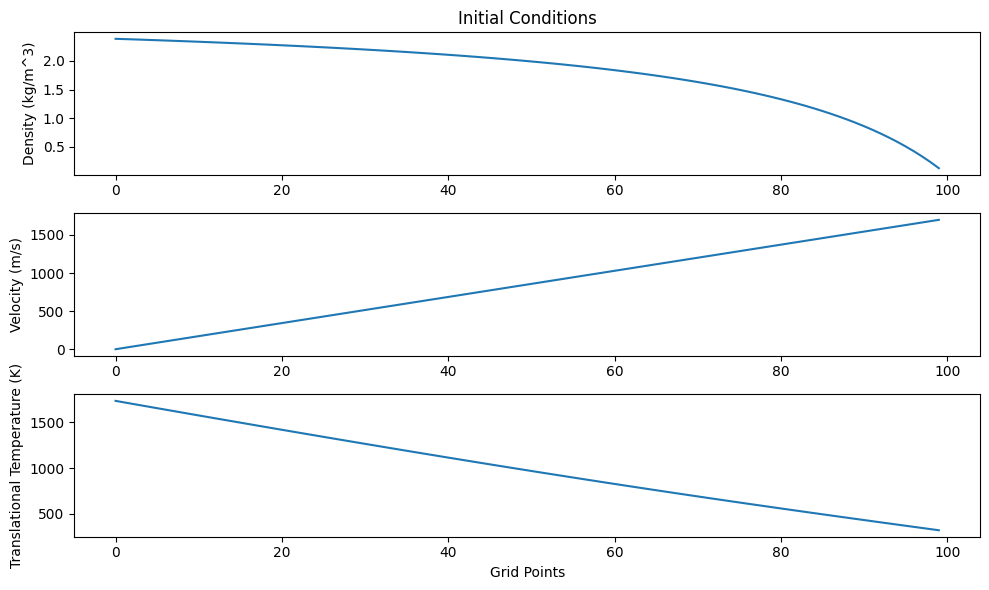

In [13]:
## Testing the creation of the initial conditions
calculate_1d_flow_eqs

def nozzle_geometry(x):
    ## constant for testing
    return np.ones_like(x) * 0.1  # m^2

P0 = 101325.0 * 10 # Pa
T0 = 1500.0  # K

y0, _ = calculate_1d_flow_eqs(0.01, 100, P0, T0, 0.09, 0.9, 0.01, nozzle_geometry)
## Plot the initial conditions
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(y0[0:100], label='Density (kg/m^3)')
plt.title('Initial Conditions')
plt.ylabel('Density (kg/m^3)')
plt.subplot(3, 1, 2)
plt.plot(y0[100:200], label='Velocity (m/s)')
plt.ylabel('Velocity (m/s)')
plt.subplot(3, 1, 3)

e = y0[200:300]
e_vib_I = y0[300:400]
e_vib_II = y0[400:500]
T = (e ) / (5/2 * 280.92)  # J/(kg·K)
plt.plot(T, label='Translational Temperature (K)')
plt.ylabel('Translational Temperature (K)')
plt.xlabel('Grid Points')
plt.tight_layout()
plt.show()
# The above code defines a function to calculate the vibrational relaxation times for a CO2-N2-H2O gas mixture,




In [14]:
def minmod_limiter(a, b):
    """Minmod flux limiter"""
    if a * b <= 0:
        return 0
    elif abs(a) < abs(b):
        return a
    else:
        return b

def apply_flux_limiters(y0, y_pred, delta_x):
    """Apply flux limiters to prevent oscillations"""
    n_points = len(y0) // 5
    
    for i in range(5):  # For each variable (rho, vel, e, e_vib_I, e_vib_II)
        start_idx = i * n_points
        end_idx = (i + 1) * n_points
        
        for j in range(1, n_points - 1):
            idx = start_idx + j
            forward_diff = y0[idx + 1] - y0[idx]
            backward_diff = y0[idx] - y0[idx - 1]
            
            # Apply limiter
            limited_slope = minmod_limiter(forward_diff, backward_diff)
            
            # Adjust the predicted value
            y_pred[idx] = y0[idx] + 0.5 * limited_slope
    
    return y_pred

In [15]:
def plot_conditions(y):
    plt.ion()  # Turn on interactive mode
    plt.clf()  # Clear the current figure
    size = len(y)//5
    plt.figure(figsize=(10, 6))
    plt.subplot(3, 1, 1)
    plt.plot(y[0:size], label='Density (kg/m^3)')
    plt.title('Initial Conditions')
    plt.ylabel('Density (kg/m^3)')
    plt.subplot(3, 1, 2)
    plt.plot(y[size:2* size], label='Velocity (m/s)')
    plt.ylabel('Velocity (m/s)')
    plt.subplot(3, 1, 3)
    e = y[size*2:size*3]
    e_vib_I = y[size*3:size*4]
    e_vib_II = y[size*4:size*5]
    plt.plot(e, label='Translational Energy (J/kg)')
    plt.plot(e_vib_I, label='Vibrational Energy I (J/kg)')
    plt.plot(e_vib_II, label='Vibrational Energy II (J/kg)')
    plt.ylabel('Energy (J/kg)')
    plt.tight_layout()
    plt.show()

In [16]:
## create function to integrate with macCormack scheme
def MacCormackIntegration(y0, time_derivative, dt, time_span, delta_x):
    n_steps = int(time_span / dt)
    current_time = 0.0
    times = [current_time]
    sol = y0.copy()
    step = 0

    while current_time < time_span:
        # solve the system using the initial conditions
        dy_dt, min_dt = time_derivative(0, y0, dir='left')

        min_dt = np.min(np.array([min_dt, dt]))/3
        # Predictor step
        y_pred = y0 + dy_dt * min_dt   
        current_time += min_dt
        times.append(current_time)
        # Corrector step
        # Calculate the right-hand side at the predicted state
        # using the predictor state
        dy_dt_pred, min_dt = time_derivative(0, y_pred, dir='right')
        min_dt = np.min(np.array([min_dt, dt]))/3
        y_pred = apply_flux_limiters(y0, y_pred, delta_x)
        # Corrector step
        dy_dt_corrected = (dy_dt + dy_dt_pred) / 2
        y0 += dy_dt_corrected * min_dt
        sol = np.vstack((sol, y0))

        
    return sol, times

In [17]:

def generate_nozzle_geometry(length, reservoir_length, throat_length, min_A, reservoir_A, exit_A):
    def smooth_interp(A1, A2, s):
        # Cosine-based smooth interpolation from A1 to A2 over s in [0,1]
        return A1 + (A2 - A1) * 0.5 * (1 - np.cos(np.pi * s))

    def nozzle_geometry(x):
        nozzle = np.zeros_like(x)
        for i, point in enumerate(x):
            if point < reservoir_length:
                # Smooth converging section
                s = point / reservoir_length
                nozzle[i] = smooth_interp(reservoir_A, min_A, s)
            elif point < reservoir_length + throat_length:
                # Constant area throat section
                nozzle[i] = min_A
            else:
                # Smooth diverging section
                s = (point - reservoir_length - throat_length) / (length - reservoir_length - throat_length)
                nozzle[i] = smooth_interp(min_A, exit_A, s)
        return nozzle
    return nozzle_geometry


/var/folders/6s/vwxlnc5s1ts9k7hbcs0kj4jh0000gn/T/ipykernel_98435/3530661048.py:39: RuntimeWarning: overflow encountered in exp
  E_vib = (c_CO2 * R * (hc * v1 / (np.exp(hc * v1 / (k * T)) - 1) + hc * v2 / (np.exp(hc * v2 / (k * T)) - 1)))/k
/var/folders/6s/vwxlnc5s1ts9k7hbcs0kj4jh0000gn/T/ipykernel_98435/3530661048.py:83: RuntimeWarning: overflow encountered in exp
  E_vib = (c_N2 * R_n2 * (hc * v1 / (np.exp(hc * v1 / (k * T)) - 1)) + c_CO2 * R_co2 * (hc * v3 / (np.exp(hc * v3 / (k * T)) - 1)))/k


<Figure size 640x480 with 0 Axes>

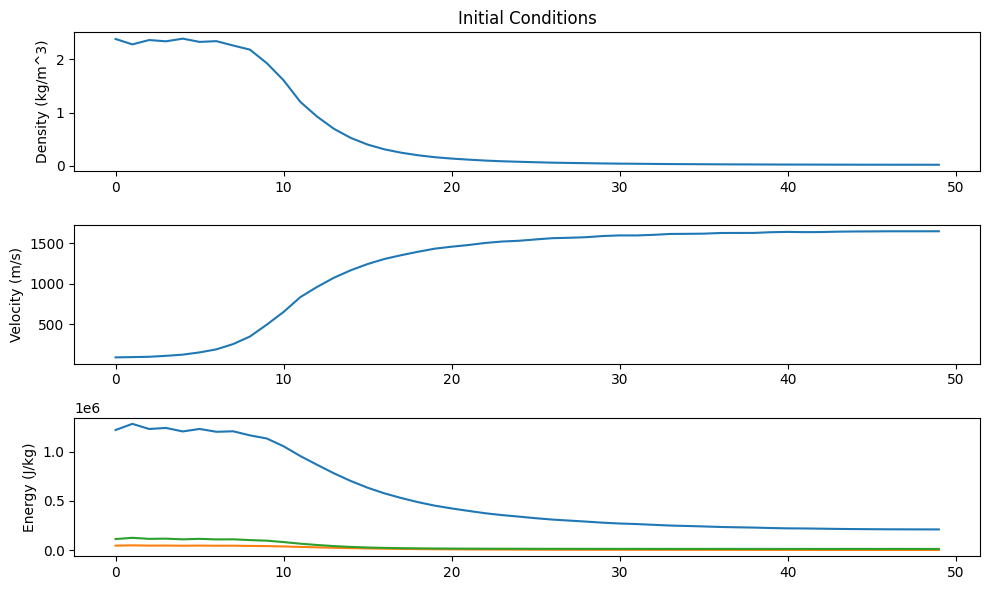

In [18]:
length = 0.4 # m
n_points = 50
delta_x = length / n_points
dt = delta_x / (400 * 1) # assumption being max speed in the nozzle is less than mach 10
time_span = 0.001
P0 = 101325.0 * 10.0 # 10 atm in pascal
T0 = 1500.0  # K

X_CO2 = 0.09
X_N2 = 0.9
X_H2O = 0.01

min_A = 0.01  # m^2
reservoir_A = 0.05  # m^2
exit_A = 0.30 # m^2

nozzle_geom = generate_nozzle_geometry(length, length * 0.2, 0, min_A, reservoir_A, exit_A)
y0, time_derivative = calculate_1d_flow_eqs(delta_x, n_points, P0, T0, X_CO2, X_N2, X_H2O, nozzle_geom, static_relaxation_times=True)

## Run the MacCormack integration
sol, times = MacCormackIntegration(y0, time_derivative, dt, time_span, delta_x)
_, time_derivative_dynamic = calculate_1d_flow_eqs(delta_x, n_points, P0, T0, X_CO2, X_N2, X_H2O, nozzle_geom, static_relaxation_times=False)
sol, times = MacCormackIntegration(sol[-1, :], time_derivative_dynamic, dt, 0.0003, delta_x)

## Plot the results
plot_conditions(sol[-3, :])

MovieWriter stderr:
[gif @ 0x151e20060] gif muxer supports only codec gif for type video
[out#0/gif @ 0x151e1ffa0] Could not write header (incorrect codec parameters ?): Invalid argument
[fc#0 @ 0x153006850] Error sending frames to consumers: Invalid argument
[fc#0 @ 0x153006850] Task finished with error code: -22 (Invalid argument)
[fc#0 @ 0x153006850] Terminating thread with return code -22 (Invalid argument)
[out#0/gif @ 0x151e1ffa0] Nothing was written into output file, because at least one of its streams received no packets.



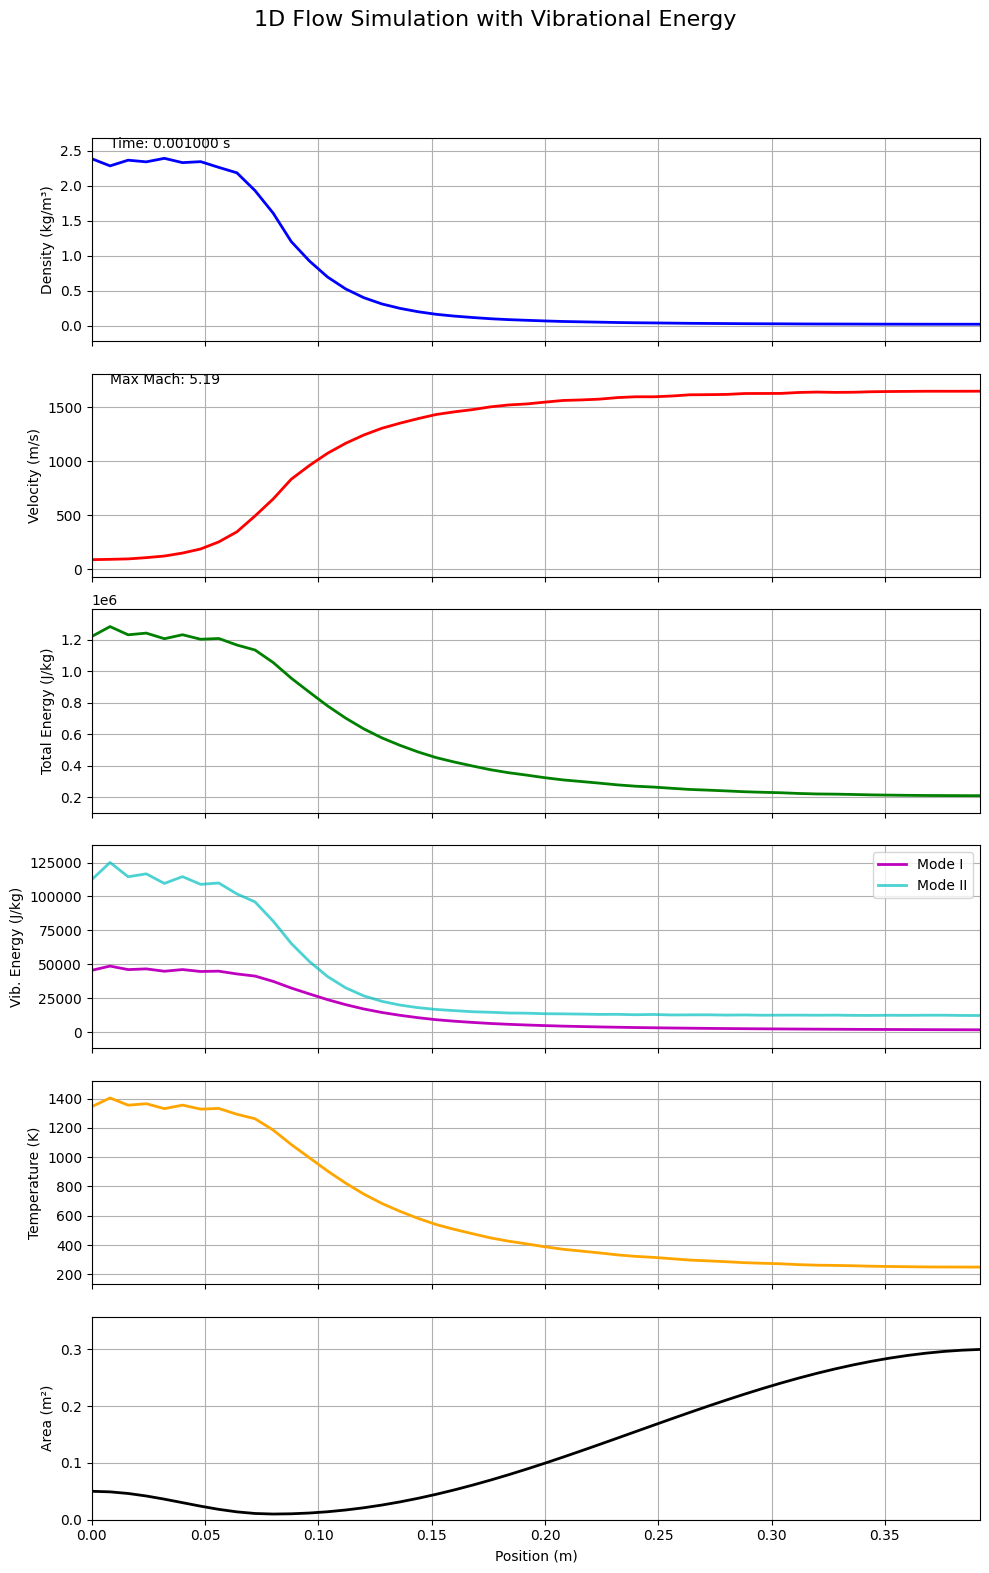

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate_flow_solution(spacing, time_span, solution, R, cv, X_CO2, X_N2, X_H2O, nozzle_geometry, max_frames=100, save_path=None):
    """
    Animate the results of the 1D flow simulation including vibrational energies.
    
    Parameters:
    -----------
    spacing : array_like
        Spatial grid points
    time_span : float
        Total simulation time
    solution : ndarray
        Solution array with shape (n_steps, 5*n_points) with variables ordered as:
        [rho, vel, e, e_vib_I, e_vib_II] for each point
    R : float
        Gas constant
    cv : float
        Specific heat at constant volume
    X_CO2, X_N2, X_H2O : float
        Mole fractions of gas components
    nozzle_geometry : callable
        Function that returns nozzle cross-sectional area for a given position
    max_frames : int, optional
        Maximum number of frames to include in the animation (default: 100)
    save_path : str, optional
        Path to save the animation (None for no saving)
        
    Returns:
    --------
    anim : FuncAnimation
        Animation object that can be displayed
    """
    
    # Extract dimensions
    n_steps, total_vars = solution.shape
    n_points = total_vars // 5  # 5 variables per grid point
    
    ## remove all NaN values
    solution = np.nan_to_num(solution)

    # remove all infs
    solution = np.where(np.isinf(solution), 0, solution)

    # Sample frames to reduce computation
    if n_steps > max_frames:
        # Select frames evenly spaced throughout the solution
        frame_indices = np.linspace(0, n_steps-1, max_frames, dtype=int)
        sampled_solution = solution[frame_indices]
        times = np.linspace(0, time_span, n_steps)[frame_indices]
    else:
        sampled_solution = solution
        times = np.linspace(0, time_span, n_steps)
    
    # Set up the figure and subplots (6 rows for density, velocity, energy, vib energies, temperature, and nozzle shape)
    fig, axs = plt.subplots(6, 1, figsize=(10, 16), sharex=True)
    fig.suptitle('1D Flow Simulation with Vibrational Energy', fontsize=16)
    
    # Initialize lines for each subplot
    rho_line, = axs[0].plot([], [], 'b-', lw=2)
    vel_line, = axs[1].plot([], [], 'r-', lw=2)
    e_line, = axs[2].plot([], [], 'g-', lw=2)
    evib_I_line, = axs[3].plot([], [], 'm-', lw=2)
    evib_II_line, = axs[3].plot([], [], 'c-', lw=2, alpha=0.7)
    temp_line, = axs[4].plot([], [], 'orange', lw=2)
    nozzle_line, = axs[5].plot(spacing, nozzle_geometry(spacing), 'k-', lw=2)
    
    # Set up the axes
    axs[0].set_ylabel('Density (kg/m³)')
    axs[1].set_ylabel('Velocity (m/s)')
    axs[2].set_ylabel('Total Energy (J/kg)')
    axs[3].set_ylabel('Vib. Energy (J/kg)')
    axs[4].set_ylabel('Temperature (K)')
    axs[5].set_ylabel('Area (m²)')
    axs[5].set_xlabel('Position (m)')
    
    # Add a legend for the vibrational energy plot
    axs[3].legend(['Mode I', 'Mode II'], loc='upper right')
    
    # Calculate min/max values for better plotting across all frames
    rho_values = solution[:, :n_points]
    vel_values = solution[:, n_points:2*n_points]
    e_values = solution[:, 2*n_points:3*n_points]
    evib_I_values = solution[:, 3*n_points:4*n_points]
    evib_II_values = solution[:, 4*n_points:5*n_points]
    
    # Calculate temperature from energy and vibrational energy
    temp_values = np.zeros_like(e_values)
    for i in range(n_steps):
        temp_values[i] = (e_values[i] - (evib_I_values[i] + evib_II_values[i])) / cv
    
    # Find min/max values for plotting with some padding
    def get_padded_limits(values, pad=0.1):
        v_min = np.min(values)
        v_max = np.max(values)
        padding = pad * (v_max - v_min) if v_max > v_min else pad
        return v_min - padding, v_max + padding
    
    # Set y-limits for each subplot
    axs[0].set_ylim(*get_padded_limits(rho_values))
    axs[1].set_ylim(*get_padded_limits(vel_values))
    axs[2].set_ylim(*get_padded_limits(e_values))
    
    # For vibrational energy, combine both modes to get limits
    all_evib = np.concatenate([evib_I_values.flatten(), evib_II_values.flatten()])

    axs[3].set_ylim(*get_padded_limits(all_evib))
    
    axs[4].set_ylim(*get_padded_limits(temp_values))
    
    # Set fixed limits for nozzle geometry
    area_min, area_max = get_padded_limits(nozzle_geometry(spacing), pad=0.2)
    axs[5].set_ylim(0, area_max)
    
    # Set x-limits for all subplots
    for ax in axs:
        ax.set_xlim(spacing[0], spacing[-1])
        ax.grid(True)
    
    # Add a time display
    time_text = axs[0].text(0.02, 0.95, '', transform=axs[0].transAxes)
    
    # Precompute mach number for display
    gamma = 1.4  # Approximation for the gas mixture
    sound_speed = np.zeros((len(sampled_solution), n_points))
    mach_number = np.zeros((len(sampled_solution), n_points))
    
    for i, frame in enumerate(sampled_solution):
        rho = frame[:n_points]
        vel = frame[n_points:2*n_points]
        e = frame[2*n_points:3*n_points]
        e_vib_I = frame[3*n_points:4*n_points]
        e_vib_II = frame[4*n_points:5*n_points]
        
        # Calculate temperature
        T = (e - (e_vib_I + e_vib_II)) / cv
        
        # Calculate sound speed: c = sqrt(gamma * R * T)
        sound_speed[i] = np.sqrt(gamma * R * T)
        
        # Calculate Mach number: M = v/c
        with np.errstate(divide='ignore', invalid='ignore'):
            mach_number[i] = np.abs(vel) / sound_speed[i]
            # Handle division by zero
            mach_number[i] = np.nan_to_num(mach_number[i])
    
    # Add a text display for maximum Mach number
    mach_text = axs[1].text(0.02, 0.95, '', transform=axs[1].transAxes)
    
    # Animation update function
    def update(frame_idx):
        # Extract the state at this time step
        frame = sampled_solution[frame_idx]
        rho = frame[:n_points]
        vel = frame[n_points:2*n_points]
        e = frame[2*n_points:3*n_points]
        e_vib_I = frame[3*n_points:4*n_points]
        e_vib_II = frame[4*n_points:5*n_points]
        
        # Calculate temperature
        T = (e - (e_vib_I + e_vib_II)) / cv
        
        # Update the plots
        rho_line.set_data(spacing, rho)
        vel_line.set_data(spacing, vel)
        e_line.set_data(spacing, e)
        evib_I_line.set_data(spacing, e_vib_I)
        evib_II_line.set_data(spacing, e_vib_II)
        temp_line.set_data(spacing, T)
        
        # Update the time and Mach number text
        time_text.set_text(f'Time: {times[frame_idx]:.6f} s')
        max_mach = np.max(mach_number[frame_idx])
        mach_text.set_text(f'Max Mach: {max_mach:.2f}')
        
        return rho_line, vel_line, e_line, evib_I_line, evib_II_line, temp_line, time_text, mach_text
    
    # Create the animation with optimized performance settings
    anim = FuncAnimation(
        fig, 
        update, 
        frames=len(times),
        interval=50,  # milliseconds between frames
        blit=True,    # only redraw the changed parts
        cache_frame_data=False  # disable caching for lower memory usage
    )
    
    # Save the animation if a path is provided
    if save_path:
        # Use a more efficient writer when available
        try:
            # Try using ffmpeg writer (faster if installed)
            writer = 'ffmpeg'
            anim.save(save_path, writer=writer, fps=30, dpi=100, 
                      extra_args=['-vcodec', 'libx264'])
        except:
            # Fall back to pillow writer
            anim.save(save_path, writer='pillow', fps=30)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    return anim

# Create and display the animation
anim = animate_flow_solution(
    spacing=np.arange(n_points) * delta_x,
    time_span=time_span,
    solution=sol[::20, :],
    R=288.92,  # J/(kg·K)
    cv=788.92,  # J/(kg·K)
    X_CO2=X_CO2,
    X_N2=X_N2,
    X_H2O=X_H2O,
    nozzle_geometry=nozzle_geom,
    max_frames=50,
    save_path='flow_animation.gif'
)

# Display the animation in a Jupyter notebook
from IPython.display import HTML
HTML(anim.to_html5_video())

Work normally for most conditions, however introducing too steep of a gradient in the nozzle creates non-physical effects in the shock when changing

Hypothesis: Simulating the system for a smaller nozzle and getting steady state and then expandin it could alleviate shocks and make the transition smoother

Text(0, 0.5, 'Proportion of Molecules in Mode')

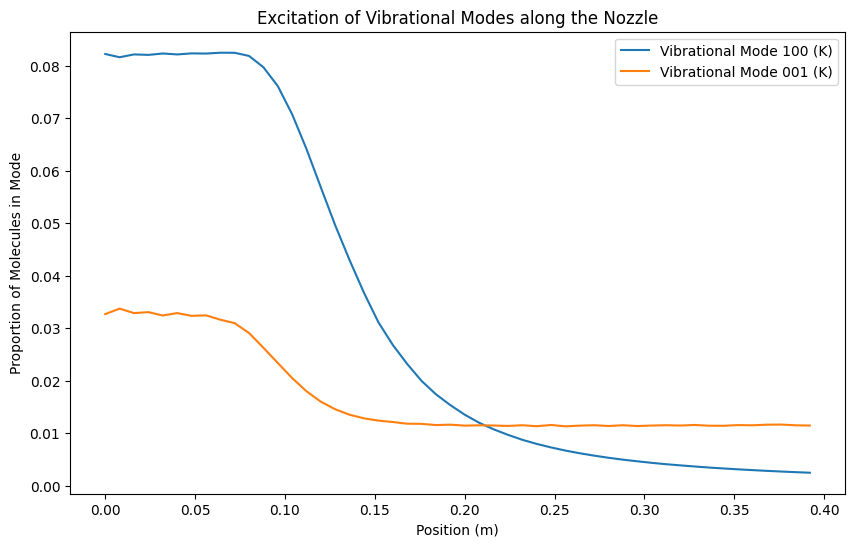

In [27]:
final_state = sol[-1, :]

def get_mode_temperature(sol, X_CO2, X_N2, X_H2O):
    """
    Calculate the vibrational temperature from the final state of the simulation.
    
    Parameters:
    -----------
    sol : ndarray
        Final state of the simulation
    X_CO2, X_N2, X_H2O : float
        Mole fractions of gas components
    
    Returns:
    --------
    tuple
        Vibrational temperatures for modes I and II
    """
    
    # Extract final state variables
    n_points = sol.shape[1] // 5
    e_vib_I = sol[-1, 3*n_points:4*n_points]
    e_vib_II = sol[-1, 4*n_points:5*n_points]
    
    # Calculate vibrational temperatures
    T_vib_I = np.zeros_like(e_vib_I)
    T_vib_II = np.zeros_like(e_vib_II)
    
    for i in range(n_points):
        T_vib_I[i] = find_vib_temperature(e_vib_I[i], X_CO2, X_N2, X_H2O, mode='I')
        T_vib_II[i] = find_vib_temperature(e_vib_II[i], X_CO2, X_N2, X_H2O, mode='II')
    
    return T_vib_I, T_vib_II

def get_population_levels(sol, X_CO2, X_N2, X_H2O):
    """
    Calculate the population levels for the vibrational modes from the final state of the simulation.
    
    Parameters:
    -----------
    sol : ndarray
        Final state of the simulation
    X_CO2, X_N2, X_H2O : float
        Mole fractions of gas components
    
    Returns:
    --------
    tuple
        Population levels for modes I and II
    """
    
    # Extract the state temperatures
    T_vib_I, T_vib_II = get_mode_temperature(sol, X_CO2, X_N2, X_H2O)

    # calculate partitions functions for CO2 mode 001 and N2 
    k = 1.380649e-23  # J/K
    hc = 6.62607015e-34 * 2.998e10 # J·cm (Planck's constant times speed of light)

    # calculate the vibrational temperatures
    exp_I = -hc / (k * T_vib_I)
    exp_II = -hc / (k * T_vib_II)

    # energy levels for all 3 transitions of CO2 in cm^-1
    v1_CO2 = 1388.0 # cm^-1
    v2_CO2 = 667.0 # cm^-1
    v3_CO2 = 2349.0 # cm^-1

    # Calculate nonequlibrium partition function for CO2
    Z_Co2 = 1/((1 - np.exp(v1_CO2 * exp_I)) * (1 - np.exp(v2_CO2 * exp_I))  * (1 - np.exp(v3_CO2 * exp_II)))

    # molar fraction of CO2 in 100 mode 
    X_100 = np.exp(v1_CO2 * exp_I) / Z_Co2
    X_001 = np.exp(v3_CO2 * exp_II) / Z_Co2

    return X_100, X_001
    

N_vib_I, N_vib_II = get_population_levels(sol, X_CO2, X_N2, X_H2O)
# Plot the vibrational temperatures
plt.figure(figsize=(10, 6))
plt.plot(np.arange(n_points) * delta_x, N_vib_I, label='Vibrational Mode 100')
plt.plot(np.arange(n_points) * delta_x, N_vib_II, label='Vibrational Mode 001')
plt.title('Excitation of Vibrational Modes along the Nozzle')
plt.legend()
plt.xlabel('Position (m)')
plt.ylabel('Proportion of Molecules in Mode')